In [1]:
import datetime
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from fairness_methods.methods import FairnessMethods
from models.basic_mf_model import BasicMatrixFactorization
from utils.data_generator import *
from utils.util import *

warnings.filterwarnings('ignore')

## Real Data Preparation

In [2]:
ml_data = generate_real_data()
ml_data

,user_id,movie_id,rating,timestamp,Sci-Fi,Musical,Action,Crime,Romance,gender,age,occupation,zip
0,1,661,3,978302109,0,1,0,0,0,F,1,10,48067
1,1,914,3,978301968,0,1,0,0,1,F,1,10,48067
2,1,1197,3,978302268,0,0,1,0,1,F,1,10,48067
3,1,1287,5,978302039,0,0,1,0,0,F,1,10,48067
4,1,594,4,978302268,0,1,0,0,0,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487930,6040,2021,3,956716374,1,0,0,0,0,M,25,6,11106
487931,6040,2028,5,956704519,0,0,1,0,0,M,25,6,11106
487932,6040,1089,4,956704996,0,0,0,1,0,M,25,6,11106
487933,6040,1094,5,956704887,0,0,0,0,1,M,25,6,11106


In [3]:
# normalize user id
ml_data["user_id"] = ml_data["user_id"].replace(
    {user_id: index for (index, user_id) in enumerate(list(ml_data["user_id"].unique()))})
ml_data["movie_id"] = ml_data["movie_id"].replace(
    {movie_id: index for (index, movie_id) in enumerate(list(ml_data["movie_id"].unique()))})

**get list of user ids by gender to relevant indexes**

In [4]:
def get_item_id_to_group(df):
    movie_id_to_index = {movie_id: index for (index, movie_id) in enumerate(df['movie_id'].unique())}
    movie_id_to_group = {}
    for row in df[["movie_id"] + GENRES].to_dict('records'):
        for index, genre in enumerate(GENRES):
            if row[genre] == 1:
                movie_id_to_group[movie_id_to_index[row['movie_id']]] = index
        if movie_id_to_index[row['movie_id']] not in movie_id_to_group:
            movie_id_to_group[movie_id_to_index[row['movie_id']]] = len(GENRES)
    return movie_id_to_group

In [5]:
def get_user_ids_by_gender(df):
    user_id_to_index = {user_id: index for (index, user_id) in enumerate(df['user_id'].unique())}
    user_gender = {}
    user_id_to_group = {}
    for row in df[["user_id", "gender"]].to_dict('records'):
        user_gender.setdefault(row['gender'], []).append(user_id_to_index[row['user_id']])
        user_id_to_group[user_id_to_index[row['user_id']]] = 1 if row['gender'] == "F" else 0
    user_gender["F"] = list(set(user_gender["F"]))
    user_gender["M"] = list(set(user_gender["M"]))
    return user_gender, user_id_to_group

In [20]:
def preprocessing(tmp_df, columns="movie_id", test_ratio=0.2, movie_len=True):
    tmp_train, tmp_test = train_test_split(tmp_df, test_size=test_ratio, shuffle=True, stratify=tmp_df[["user_id"]])
    tmp_train = tmp_train[tmp_train[columns].isin(tmp_test[columns].unique())]
    tmp_user_gender, tmp_user_id_to_group = get_user_ids_by_gender(tmp_df)
    item_to_group = get_item_id_to_group(tmp_df) if movie_len else {}
    tmp_train_set = pd.pivot_table(tmp_train, values='rating', index='user_id', columns=columns)
    tmp_test = pd.pivot_table(tmp_test, values='rating', index='user_id', columns=columns)
    number_of_items = max(tmp_train_set.shape[1], tmp_test.shape[1])
    tmp_train_set.columns = range(tmp_train_set.shape[1])
    tmp_test.columns = range(tmp_test.shape[1])
    # normalize number of items
    # for item_id in range(number_of_items):
    #     if item_id not in list(tmp_test.columns):
    #         tmp_test[item_id] = np.nan
    #     if item_id not in list(tmp_train_set.columns):
    #         tmp_train_set[item_id] = np.nan
    tmp_train_set.fillna(0, inplace=True)
    print("train_set shape: ", tmp_train_set.shape, " test_set shape: ", tmp_test.shape)
    return tmp_train_set, tmp_test.to_numpy(), tmp_user_gender, tmp_user_id_to_group, item_to_group

In [7]:
def train_and_predict(model_train_set, group_user, group_item, n_users, n_items, epochs=20, n_factors=20):
    model = BasicMatrixFactorization(n_users=model_train_set.shape[0], n_items=model_train_set.shape[1], epochs=epochs,
                                     n_factors=n_factors)
    model.fit(X=model_train_set.to_numpy(), group_user=group_user, group_item=group_item)
    preds = model.predictions()
    return preds

In [8]:
def evaluate(model_test_set, model_test_name, model_predictions, model_user_gender, number_of_columns):
    return {"test_name": model_test_name,
            # "rmse": RecommendationSystemMetrics().RMSE(true_array=model_test_set, pred_array=model_predictions),
            "val_score": FairnessMethods().calculate_val_score(model_predictions, model_test_set,
                                                               np.array(model_user_gender["M"]),
                                                               np.array(model_user_gender["F"]),
                                                               number_of_columns),
            "abs_score": FairnessMethods().calculate_abs_score(model_predictions, model_test_set,
                                                               np.array(model_user_gender["M"]),
                                                               np.array(model_user_gender["F"]),
                                                               number_of_columns),
            "under_score": FairnessMethods().calculate_under_score(model_predictions, model_test_set,
                                                                   np.array(model_user_gender["M"]),
                                                                   np.array(model_user_gender["F"]),
                                                                   number_of_columns),
            "over_score": FairnessMethods().calculate_over_score(model_predictions, model_test_set,
                                                                 np.array(model_user_gender["M"]),
                                                                 np.array(model_user_gender["F"]),
                                                                 number_of_columns),
            "parity_score": FairnessMethods().calculate_non_parity_score(model_predictions,
                                                                         np.array(model_user_gender["M"]),
                                                                         np.array(model_user_gender["F"]))}

**rating matrix analysis**

In [9]:
ratings = pd.pivot_table(ml_data, values='rating', index='user_id', columns='movie_id')
ratings.fillna(0, inplace=True)

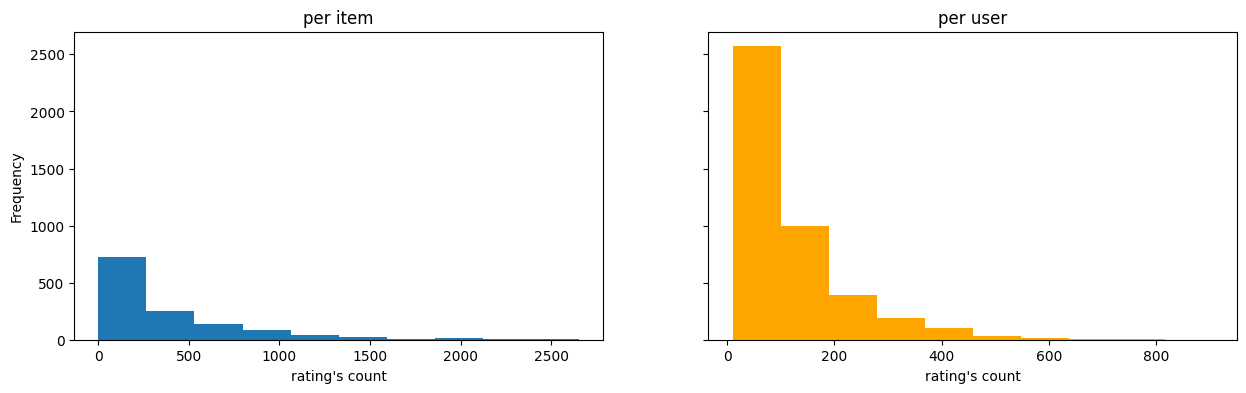

In [10]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1], color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

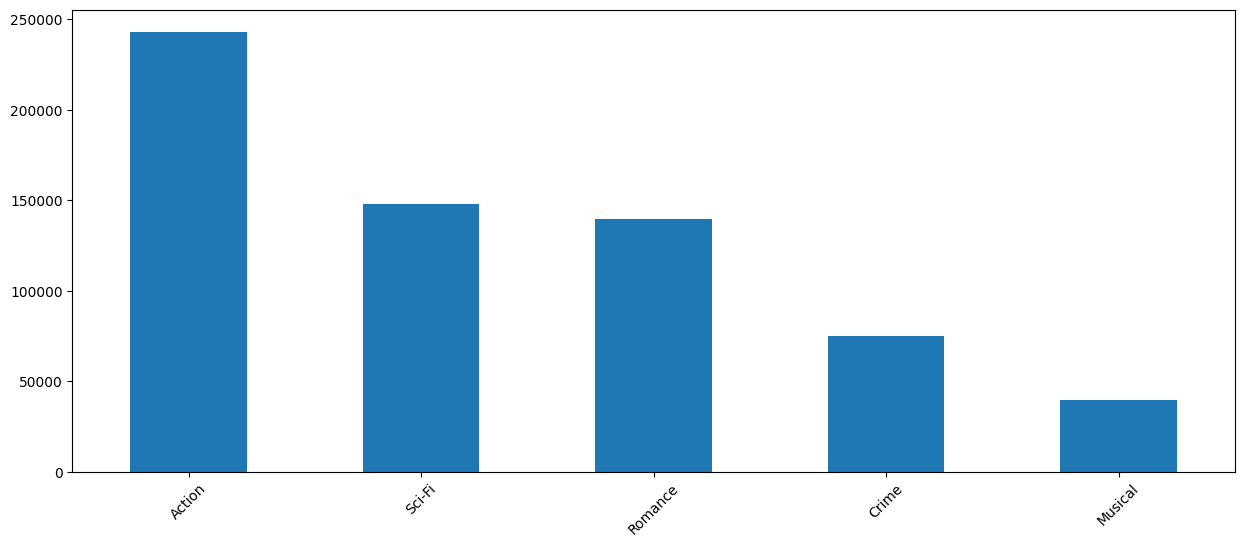

In [11]:
plt.figure(figsize=(15, 6))
ml_data[GENRES].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

## Training Basic Matrix Factorization Model and calculate fairness matrices

In [12]:
results = []
# for test_id in range(1, NUMBER_OF_TESTS + 1):
for test_id in range(1, 3):
    print(f"start run MF model number {test_id}")
    start_time = datetime.datetime.now()
    train_set, test_set, tmp_user_gender, tmp_user_id_to_group, item_to_group = preprocessing(ml_data)
    print(f"input shape: {train_set.shape}")
    predictions = train_and_predict(train_set, group_user=tmp_user_id_to_group, group_item=item_to_group,
                                    n_users=len(ml_data["user_id"].unique()), n_items=len(ml_data["movie_id"].unique()))
    results.append(evaluate(model_test_set=test_set, model_test_name=str(test_id), model_predictions=predictions,
                            model_user_gender=tmp_user_gender, number_of_columns=train_set.shape[1]))

    end_time = datetime.datetime.now()
    print(f"finished run MF model number {test_id} after {(end_time - start_time).seconds} seconds")

start run MF model number 1
train_set shape:  (4297, 1262)  test_set shape:  (4297, 1266)
input shape: (4297, 1262)
init model with n_users=4297, n_items=1262, n_user_groups=2
finished run MF model number 1 after 199 seconds
start run MF model number 2
train_set shape:  (4297, 1259)  test_set shape:  (4297, 1265)
input shape: (4297, 1259)
init model with n_users=4297, n_items=1259, n_user_groups=2
finished run MF model number 2 after 198 seconds


In [13]:
pd.DataFrame(results).describe()

,val_score,abs_score,under_score,over_score,parity_score
count,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.435266,0.274513,0.216571,0.218695,0.165150
std,0.015357,0.006337,0.007996,0.007362,0.028149
min,0.424407,0.270032,0.210917,0.213489,0.145246
25%,0.429836,0.272272,0.213744,0.216092,0.155198
50%,0.435266,0.274513,0.216571,0.218695,0.165150
75%,0.440696,0.276753,0.219398,0.221298,0.175102
max,0.446125,0.278993,0.222225,0.223900,0.185054


<Axes: >

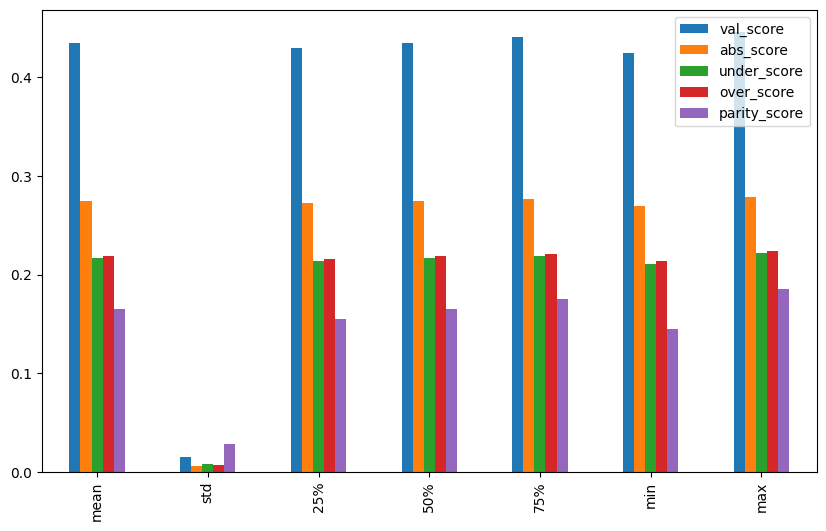

In [14]:
pd.DataFrame(results).describe().loc[["mean", "std", "25%", "50%", "75%", "min", "max"]].plot(kind='bar',
                                                                                              figsize=(10, 6),
                                                                                              legend=True)

## Synthetic Data Preparation

In [15]:
# uniform user groups and uniform observation probabilities (U)
U_ratings, U_item_id_to_group = generate_synthetic_data(observation_model='uniform', user_distribution='uniform')
# uniform user groups and biased observation probabilities (O)
O_ratings, O_item_id_to_group = generate_synthetic_data(observation_model='unbalanced', user_distribution='uniform')
# biased user groups and uniform observation probabilities (P)
P_ratings, P_item_id_to_group = generate_synthetic_data(observation_model='uniform', user_distribution='imbalanced')
# biased user groups and biased observation probabilities (OP)
OP_ratings, OP_item_id_to_group = generate_synthetic_data(observation_model='unbalanced',
                                                          user_distribution='imbalanced')
synthetic_tests_df = {"U": U_ratings, "O": O_ratings, "P": P_ratings, "OP": OP_ratings}
synthetic_tests_item_groups = {"U": U_item_id_to_group, "O": O_item_id_to_group, "P": P_item_id_to_group,
                               "OP": OP_item_id_to_group}

****************************rating probability****************************

╒════╤═══════╤════════╤════════╕
│    │   Fem │   STEM │   Masc │
╞════╪═══════╪════════╪════════╡
│ W  │   0.8 │    0.2 │    0.2 │
├────┼───────┼────────┼────────┤
│ WS │   0.8 │    0.8 │    0.2 │
├────┼───────┼────────┼────────┤
│ M  │   0.2 │    0.8 │    0.8 │
├────┼───────┼────────┼────────┤
│ MS │   0.2 │    0.2 │    0.8 │
╘════╧═══════╧════════╧════════╛
****************************observation probability****************************

╒════╤═══════╤════════╤════════╕
│    │   Fem │   STEM │   Masc │
╞════╪═══════╪════════╪════════╡
│ W  │   0.4 │    0.4 │    0.4 │
├────┼───────┼────────┼────────┤
│ WS │   0.4 │    0.4 │    0.4 │
├────┼───────┼────────┼────────┤
│ M  │   0.4 │    0.4 │    0.4 │
├────┼───────┼────────┼────────┤
│ MS │   0.4 │    0.4 │    0.4 │
╘════╧═══════╧════════╧════════╛
****************************rating probability****************************

╒════╤═══════╤════════╤════════╕
│    │  

In [26]:
synthetic_results = []
for test_name, tmp_df_ratings in synthetic_tests_df.items():
    agg_evaluation = {}
    for index in range(1, NUMBER_OF_TESTS + 1):
        print(f"start run MF model test '{test_name}'")
        start_time = datetime.datetime.now()
        train_set, test_set, tmp_user_gender, tmp_user_id_to_group, _ = preprocessing(tmp_df_ratings, columns="item_id",
                                                                                      movie_len=False)
        print(f"input shape: {train_set.shape}")
        predictions = train_and_predict(train_set, group_user=tmp_user_id_to_group,
                                        group_item=synthetic_tests_item_groups[test_name],
                                        n_users=len(tmp_df_ratings["user_id"].unique()),
                                        n_items=len(tmp_df_ratings["item_id"].unique()))
        tmp_evaluation = evaluate(model_test_set=test_set, model_test_name=test_name, model_predictions=predictions,
                                  model_user_gender=tmp_user_gender, number_of_columns=train_set.shape[1])
        for key, value in tmp_evaluation.items():
            if key != "test_name":
                agg_evaluation.setdefault(key, []).append(value)
        end_time = datetime.datetime.now()
        print(f"finished run MF model test '{test_name} - {index}' after {(end_time - start_time).seconds} seconds")
    test_results = {"test_name": test_name}
    for key, value in agg_evaluation.items():
        test_results[key] = np.mean(value)
    synthetic_results.append(test_results)

start run MF model test 'U'
train_set shape:  (400, 300)  test_set shape:  (400, 300)
input shape: (400, 300)
init model with n_users=400, n_items=300, n_user_groups=2
finished run MF model test 'U - 1' after 11 seconds
start run MF model test 'U'
train_set shape:  (400, 300)  test_set shape:  (400, 300)
input shape: (400, 300)
init model with n_users=400, n_items=300, n_user_groups=2
finished run MF model test 'U - 2' after 11 seconds
start run MF model test 'U'
train_set shape:  (400, 300)  test_set shape:  (400, 300)
input shape: (400, 300)
init model with n_users=400, n_items=300, n_user_groups=2
finished run MF model test 'U - 3' after 10 seconds
start run MF model test 'U'
train_set shape:  (400, 300)  test_set shape:  (400, 300)
input shape: (400, 300)
init model with n_users=400, n_items=300, n_user_groups=2
finished run MF model test 'U - 4' after 10 seconds
start run MF model test 'U'
train_set shape:  (400, 300)  test_set shape:  (400, 300)
input shape: (400, 300)
init model

In [27]:
synthetic_results_df = pd.DataFrame(synthetic_results)
synthetic_results_df.set_index('test_name', inplace=True)
synthetic_results_df.describe()

,val_score,abs_score,under_score,over_score,parity_score
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,1.336823,1.157340,1.246823,0.089999,0.286822
std,0.297270,0.318727,0.308188,0.012705,0.164958
min,1.019312,0.818992,0.918602,0.076162,0.061826
25%,1.136109,0.935318,1.035281,0.080733,0.218107
50%,1.321832,1.145284,1.233317,0.091483,0.325020
75%,1.522545,1.367305,1.444859,0.100749,0.393734
max,1.684315,1.519801,1.602058,0.100868,0.435423


<Axes: >

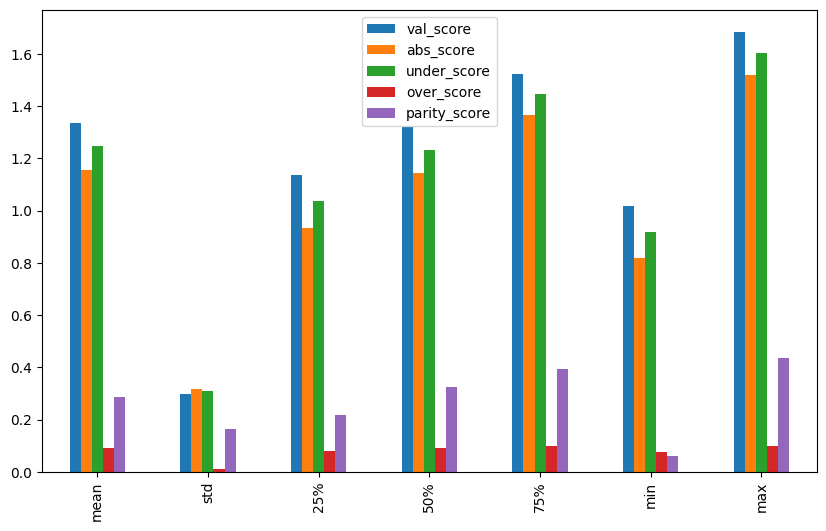

In [28]:
synthetic_results_df.loc[:, synthetic_results_df.columns != 'test_name'].describe().loc[
    ["mean", "std", "25%", "50%", "75%", "min", "max"]].plot(kind='bar',
                                                             figsize=(10, 6),
                                                             legend=True)

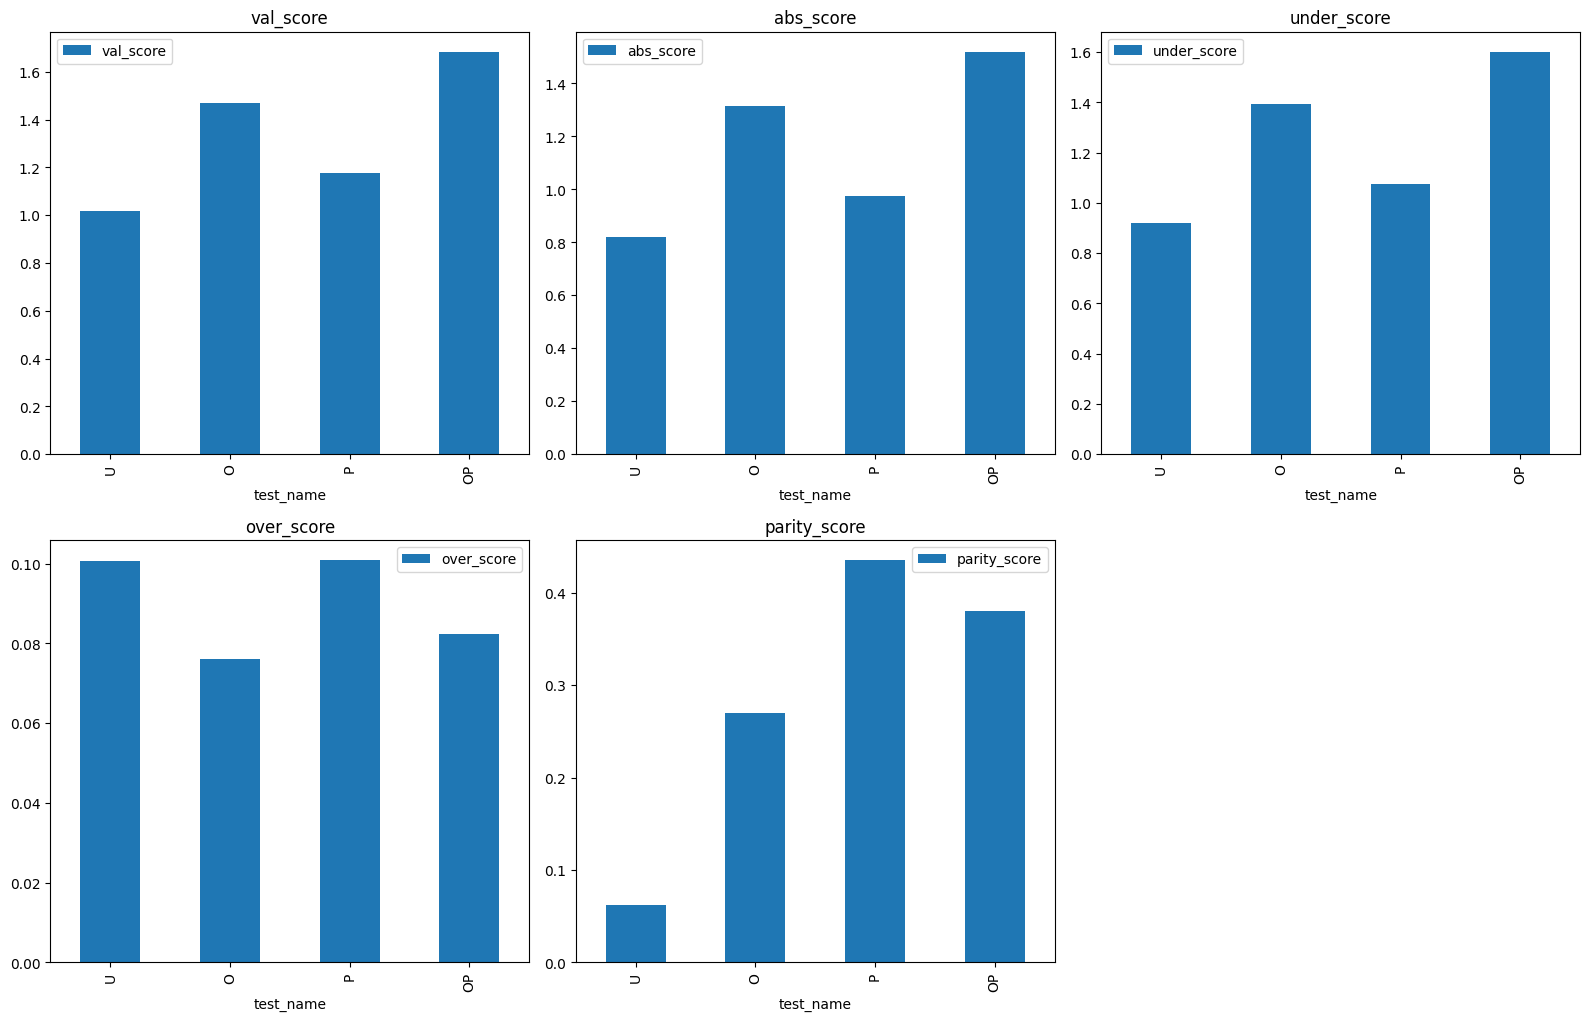

In [29]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(["val_score", "abs_score", "under_score", "over_score", "parity_score"]):
    plt.subplot(4, 3, i + 1)
    synthetic_results_df[col].plot(kind='bar', legend=True)
    plt.title(col)
    plt.tight_layout()
plt.show()